# Gait Phase Cycle Analysis

##Importing Libraries & Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# New Section

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from scipy.signal import savgol_filter, find_peaks

In [ ]:
df = pd.read_csv("drive/MyDrive/project_csv_data/gait_Janvi_1_2.csv")
df.head()

,y,timestamps
0,10.69,173736
1,10.46,173758
2,10.56,173780
3,10.89,173802
4,11.48,173824


## Preprocessing

In [ ]:
# # Step 2: Preprocessing
# def butter_lowpass(cutoff, fs, order=5):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = filtfilt(b, a, data)
#     return y

# # Choose cutoff frequency and filter the magnitude data
# cutoff_frequency = 7.0  # Adjust as needed
# fs = 85.0  # Sample rate (assuming timestamps are in milliseconds)
# df['mag_filtered'] = butter_lowpass_filter(df['mag'], cutoff_frequency, fs)

**Selection of noise-reduction filter:** where preserving the shape and timing of heel strikes and toe-offs is critical, the Savitzky-Golay filter is often preferred. This is because it's designed to maintain the local shape of data features while removing noise.


In [ ]:
df.y.index = df.timestamps - 173736

In [ ]:
# Step 2: Preprocessing with Savitzky-Golay filter
window_length = 21  # Adjust the window length as needed
polyorder = 3  # Adjust the polynomial order as needed

df['mag_filtered'] = savgol_filter(df['y'], window_length, polyorder)

<Axes: xlabel='timestamps'>

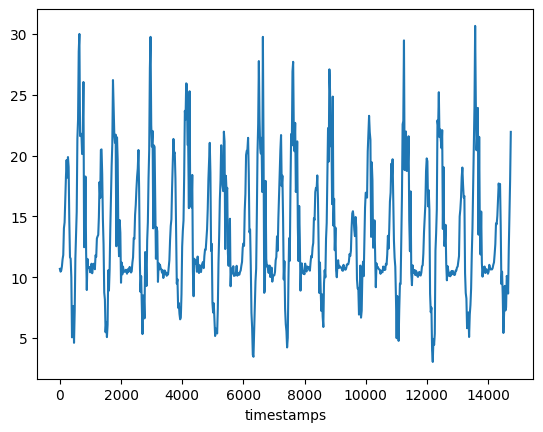

In [ ]:
df.y.plot()

In [ ]:
df.mag_filtered.index = df.timestamps - 173736

<Axes: xlabel='timestamps'>

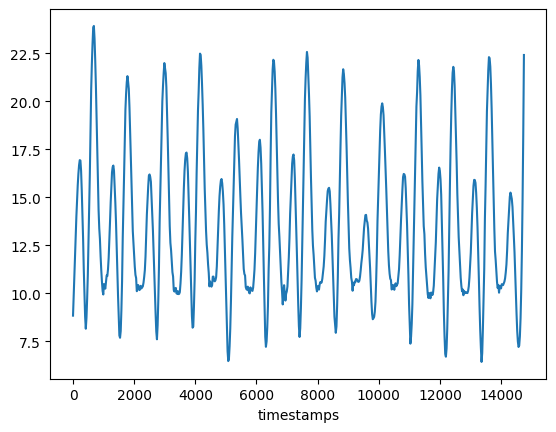

In [ ]:
df.mag_filtered.plot()

## Phase Calculation

In [ ]:
# Peak Detection
# Find local peaks in the filtered magnitude data
peaks, _ = find_peaks(df['mag_filtered'], height=14, distance=50)  # Adjust the height threshold as needed

# Identify key events (heel strikes and toe-offs)
heel_strike_timestamps = df.iloc[peaks]['timestamps']
heel_strike_time = heel_strike_timestamps - 173736
print("heel strike time (ms): \n", heel_strike_time)
gait_cycle_duration = np.diff(heel_strike_timestamps)

print("gait cycle duration (ms): ",gait_cycle_duration)

heel strike time (ms): 
 31       682
81      1780
136     2987
189     4153
244     5363
298     6551
348     7651
402     8836
460    10112
514    11296
566    12437
619    13603
Name: timestamps, dtype: int64
gait cycle duration (ms):  [1098 1207 1166 1210 1188 1100 1185 1276 1184 1141 1166]


###Normalization

Normalize the acceleration data within each gait cycle. This step ensures that variations in step length or walking speed do not affect the phase calculations.

In [ ]:
df['gait_phase'] = 0

# Normalize the gait cycle by dividing by its duration
for i in range(len(heel_strike_timestamps) - 1):
    cycle_start = heel_strike_timestamps.iloc[i]
    cycle_end = heel_strike_timestamps.iloc[i + 1]
    mask = (df['timestamps'] >= cycle_start) & (df['timestamps'] <= cycle_end)
    df.loc[mask, 'gait_phase'] = ((df['timestamps'][mask] - cycle_start) / (cycle_end - cycle_start)) * 100

# Handle the last gait cycle separately
last_cycle_start = heel_strike_timestamps.iloc[-1]
last_cycle_end = heel_strike_timestamps.iloc[-1] + gait_cycle_duration[-1]
mask = (df['timestamps'] >= last_cycle_start) & (df['timestamps'] <= last_cycle_end)
df.loc[mask, 'gait_phase'] = ((df['timestamps'][mask] - last_cycle_start) / (last_cycle_end - last_cycle_start)) * 100

In [ ]:
df.gait_phase

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
667    90.566038
668    92.452830
669    94.339623
670    96.226415
671    98.113208
Name: gait_phase, Length: 672, dtype: float64

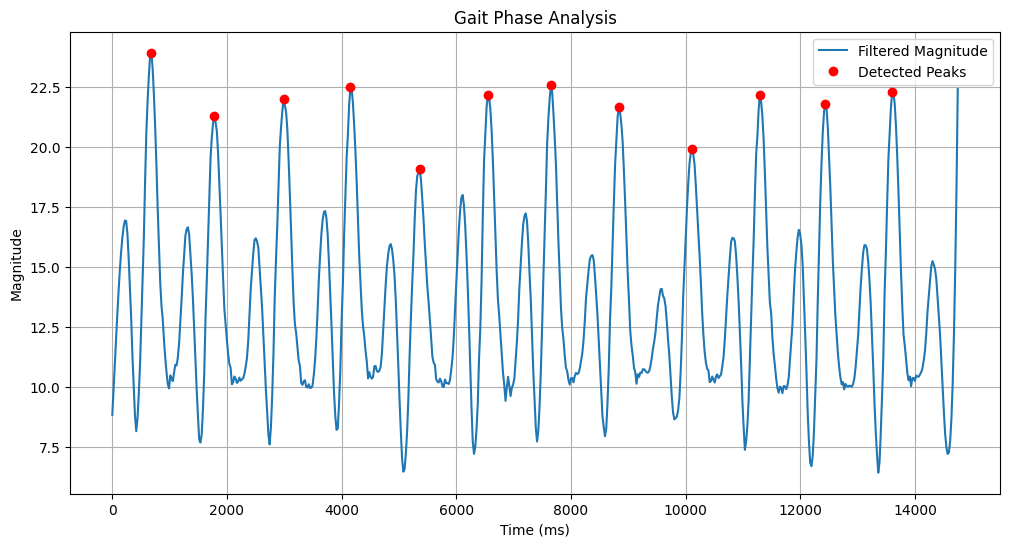

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamps'] - 173736, df['mag_filtered'], label='Filtered Magnitude')
plt.plot(df.iloc[peaks]['timestamps'] - 173736, df.iloc[peaks]['mag_filtered'], 'ro', label='Detected Peaks')
plt.xlabel('Time (ms)')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Gait Phase Analysis')
plt.grid(True)
plt.show()

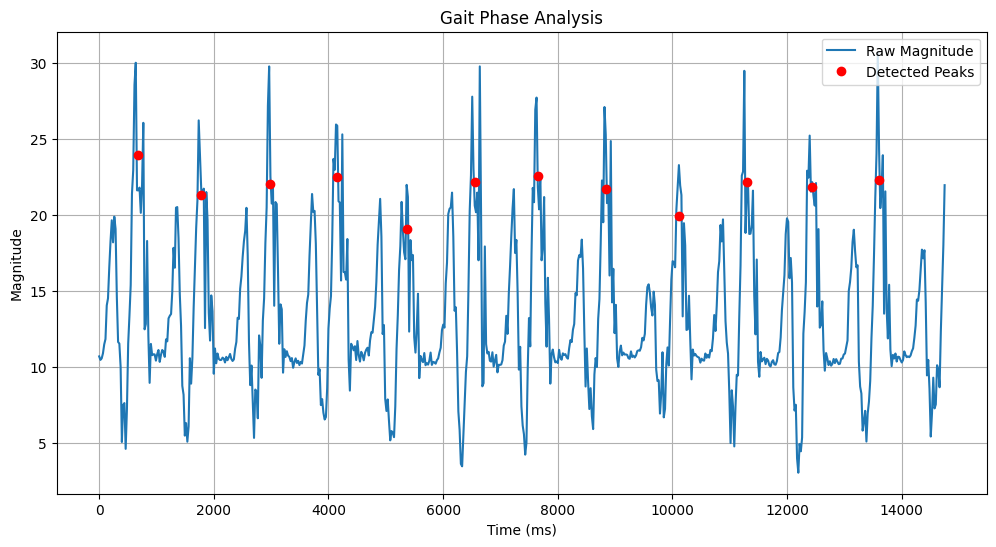

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamps'] - 173736, df['y'], label='Raw Magnitude')
plt.plot(df.iloc[peaks]['timestamps'] - 173736, df.iloc[peaks]['mag_filtered'], 'ro', label='Detected Peaks')
plt.xlabel('Time (ms)')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Gait Phase Analysis')
plt.grid(True)
plt.show()

## Average Gait Phase Cycle

In [ ]:
# Average Gait Phase Cycle
average_gait_phase_cycle = df.groupby('gait_phase').mean()
average_gait_phase_cycle.reset_index(inplace=True)

In [ ]:
print(average_gait_phase_cycle)

     gait_phase          y     timestamps  mag_filtered
0      0.000000  16.824884  175961.139535     16.399542
1      1.724138  20.770000  182594.000000     21.431677
2      1.818182  20.890000  177911.000000     22.423880
3      1.822701  21.060000  175538.000000     21.019274
4      1.851852  21.170000  179121.000000     18.603655
..          ...        ...            ...           ...
515   98.143460  27.090000  182550.000000     21.257986
516   98.148148  23.030000  180265.000000     21.666711
517   98.177299  29.760000  176701.000000     21.478938
518   98.181818  17.080000  179077.000000     18.939984
519   98.275862  21.840000  183826.000000     19.732161

[520 rows x 4 columns]


<Axes: title={'center': 'Average gait cycle of raw data'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

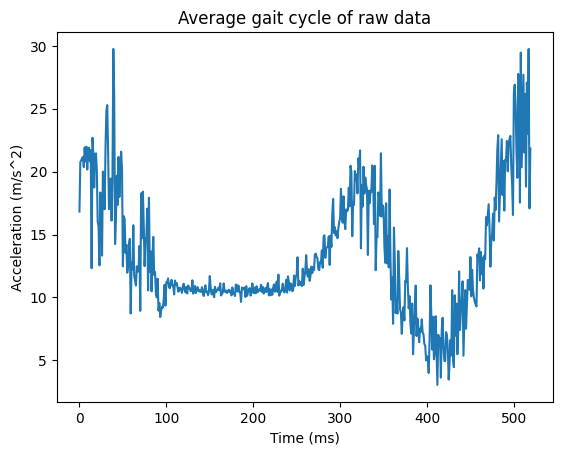

In [ ]:
average_gait_phase_cycle.y.plot(title="Average gait cycle of raw data", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

<Axes: title={'center': 'Average gait cycle of Denoised data'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

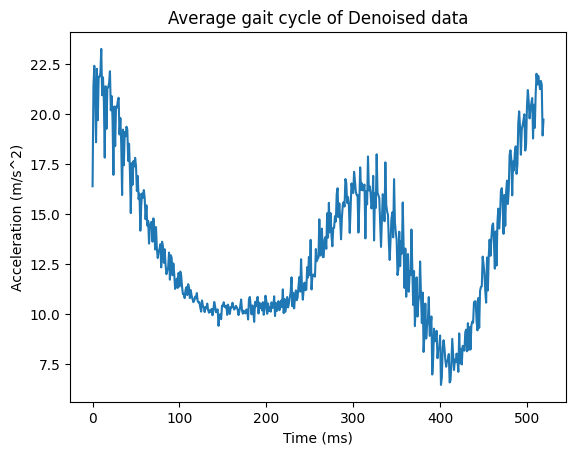

In [ ]:
average_gait_phase_cycle.mag_filtered.plot(title="Average gait cycle of Denoised data", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

<Axes: title={'center': 'Zoomed view of average cycle of raw data'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

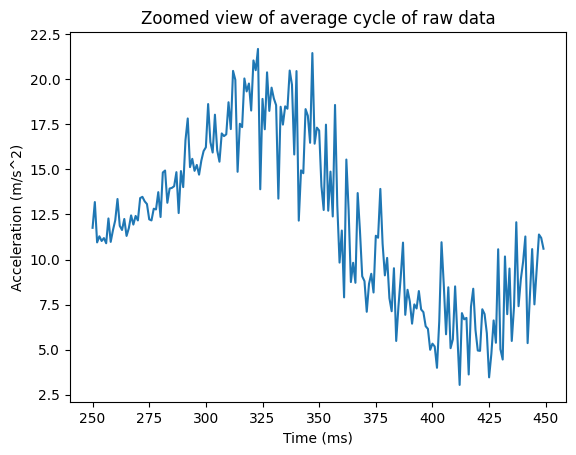

In [ ]:
average_gait_phase_cycle.y.iloc[250:450].plot(title="Zoomed view of average cycle of raw data", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

<Axes: title={'center': 'Zoomed view of average cycle of denoised data'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

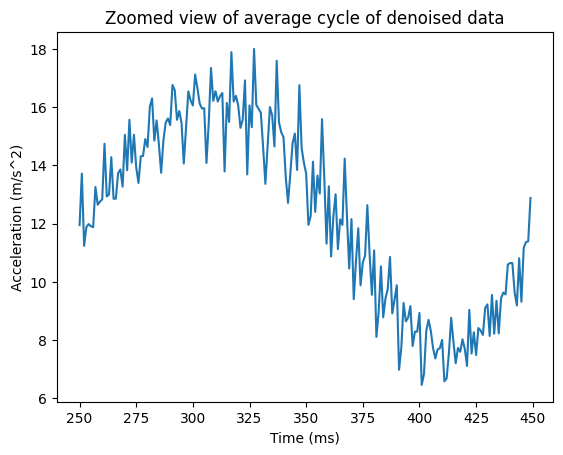

In [ ]:
average_gait_phase_cycle.mag_filtered.iloc[250:450].plot(title="Zoomed view of average cycle of denoised data", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

In [ ]:
smoothen_cycle2 = average_gait_phase_cycle.mag_filtered.iloc[250:460].rolling(window=10).mean()

<Axes: title={'center': 'Zoomed view of average cycle of raw data (Smoothen by moving avg filter)'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

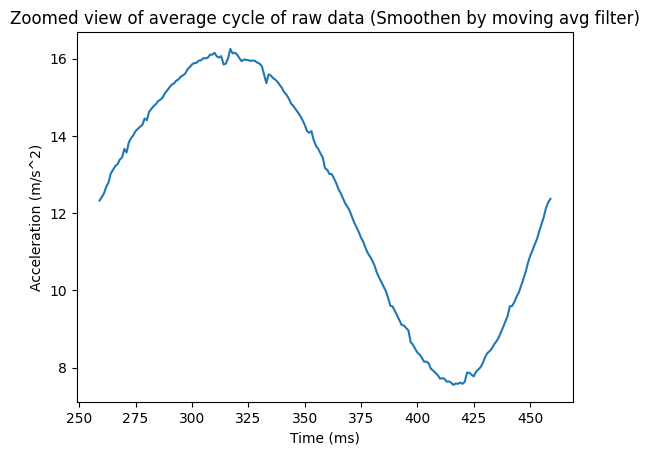

In [ ]:
smoothen_cycle2.plot(title="Zoomed view of average cycle of raw data (Smoothen by moving avg filter)", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

### Statistics of Zoomed Inner Cycle

In [ ]:
inner_cycle = average_gait_phase_cycle.y.iloc[250:450]

inner_cycle.describe()

count    200.000000
mean      12.090292
std        4.621153
min        3.040000
25%        8.230000
50%       12.115000
75%       15.560000
max       21.690000
Name: y, dtype: float64

Text(0, 0.5, 'Acceleration (m/s^2)')

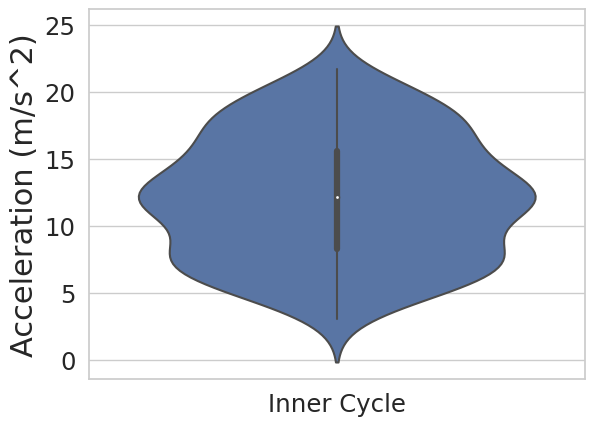

In [ ]:
import seaborn

seaborn.set(font_scale = 1.6, style = 'whitegrid')

tip = seaborn.load_dataset('tips')

# Pandas dataframe
data = pd.DataFrame({"Inner Cycle": inner_cycle})

plots = seaborn.violinplot(data = data)

plots.set_ylabel("Acceleration (m/s^2)", fontsize = 22)

In [ ]:
from scipy.stats import norm, kde

# Compute the PDF using KDE
kde = kde.gaussian_kde(inner_cycle)
x = np.linspace(inner_cycle.min(), inner_cycle.max(), 1000)  # Generate a range of values for the x-axis
pdf_values = kde(x)

<ipython-input-26-54850dc99230>:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde = kde.gaussian_kde(inner_cycle)


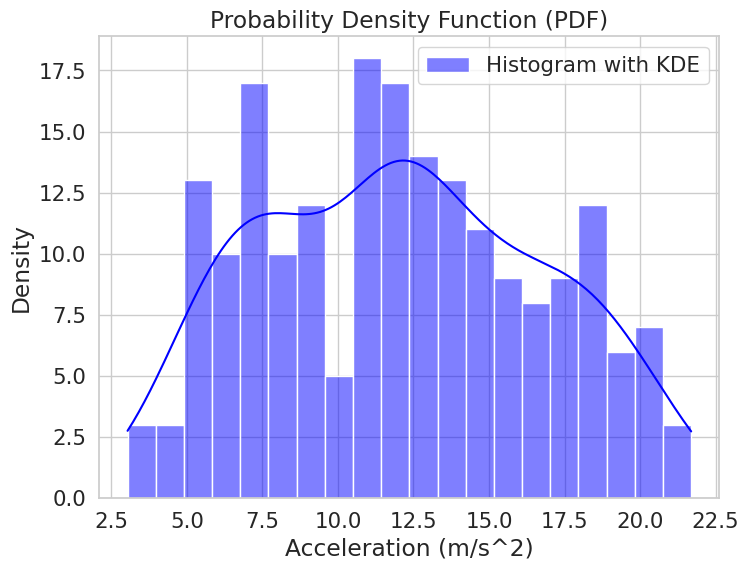

In [ ]:
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(8, 6))
ax = sns.histplot(inner_cycle, kde=True, color='blue', bins=20, label='Histogram with KDE')  # Plot histogram with KDE

ax.set_xlabel('Acceleration (m/s^2)')
ax.set_ylabel('Density')
ax.set_title('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**Future Work**: We can try out the butterworth low-pass filter after identifying the contact points and can calculate these statistics for denoised cycle with this filter.

##Trying out low-pass filtering

In [ ]:
# Step 2: Preprocessing
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Choose cutoff frequency and filter the magnitude data
cutoff_frequency = 5.0  # Adjust as needed
fs = 90.0  # Sample rate (assuming timestamps are in milliseconds)
df['mag_filtered_lp'] = butter_lowpass_filter(df['y'], cutoff_frequency, fs)

<Axes: title={'center': 'Low-pass Butterworth filter'}, xlabel='time(ms)', ylabel='Acceleration (m/s^2)'>

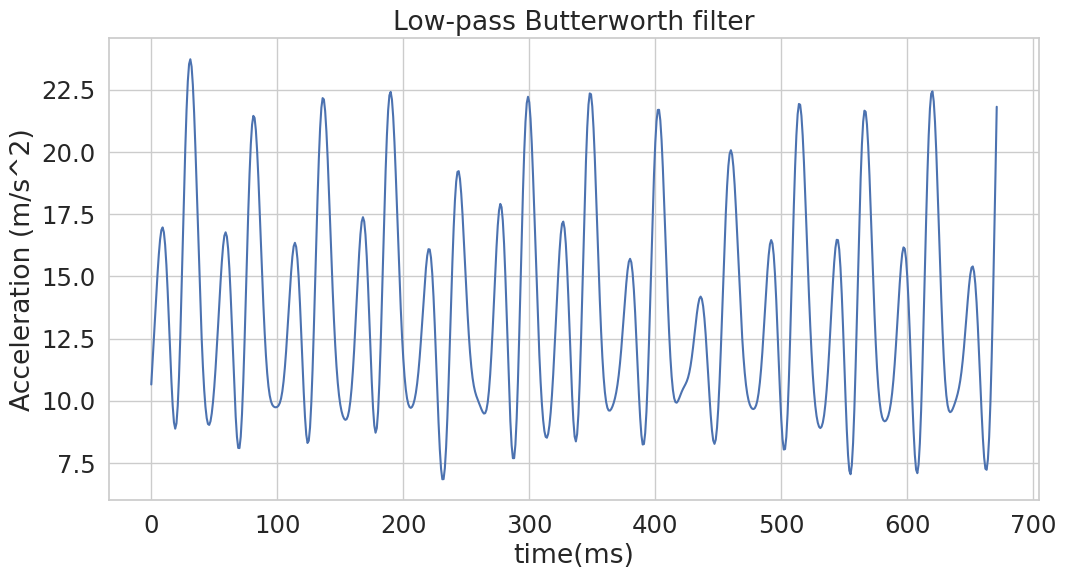

In [ ]:
plt.figure(figsize=(12, 6))
df.mag_filtered_lp.plot(title="Low-pass Butterworth filter", xlabel="time(ms)", ylabel="Acceleration (m/s^2)")

<Axes: title={'center': 'Savotzky-Golay filter'}, xlabel='time(ms)', ylabel='Acceleration (m/s^2)'>

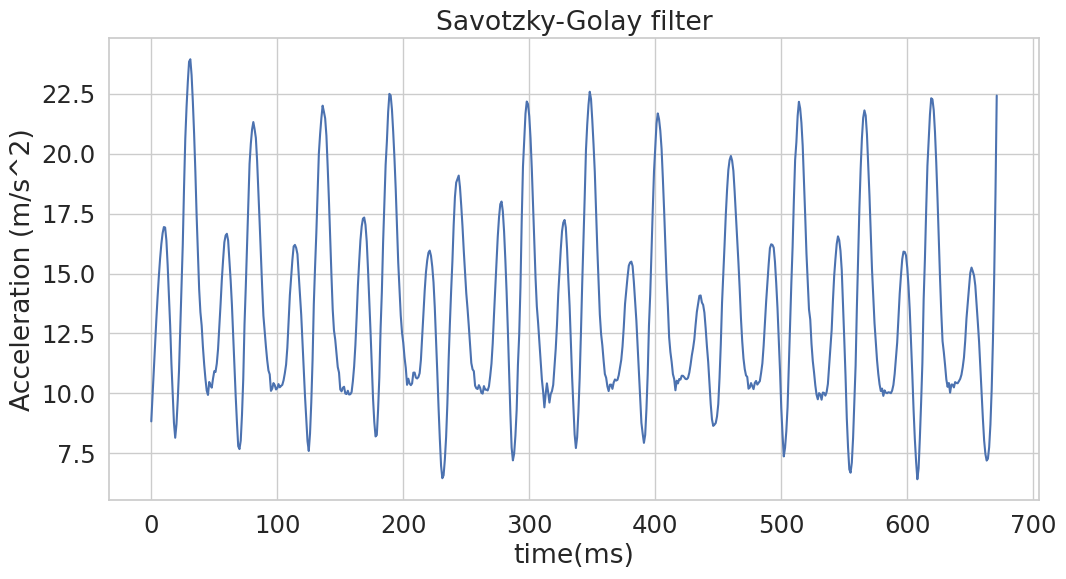

In [ ]:
plt.figure(figsize=(12,6))
df.mag_filtered.plot(title="Savotzky-Golay filter", xlabel="time(ms)", ylabel="Acceleration (m/s^2)")

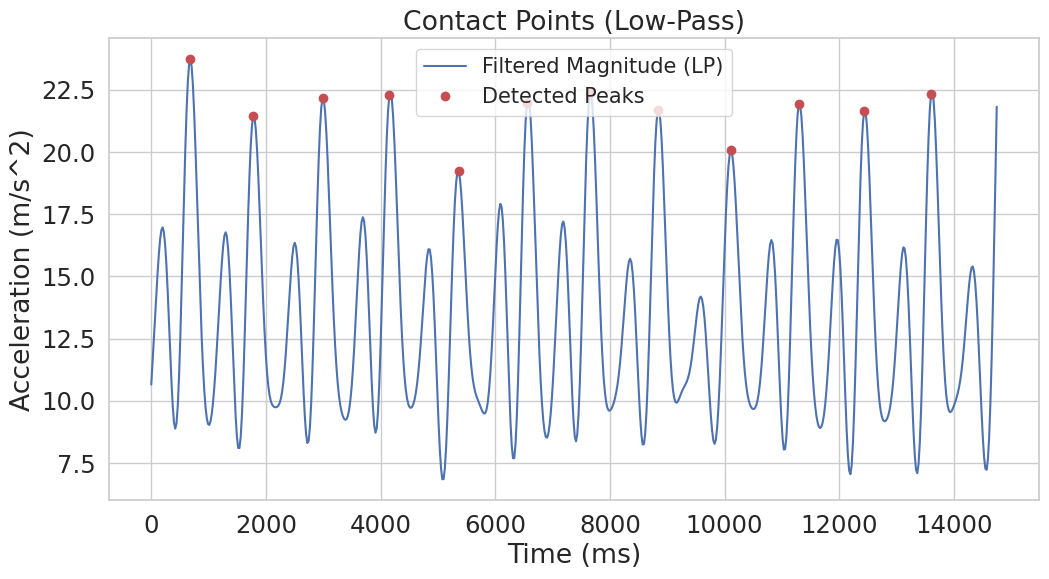

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamps'] - 173736, df['mag_filtered_lp'], label='Filtered Magnitude (LP)')
plt.plot(df.iloc[peaks]['timestamps'] - 173736, df.iloc[peaks]['mag_filtered_lp'], 'ro', label='Detected Peaks')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(fontsize=15)
plt.title('Contact Points (Low-Pass)')
plt.grid(True)
plt.show()

In [ ]:
# Average Gait Phase Cycle
average_gait_phase_cycle_lp = df.groupby('gait_phase').mean()
average_gait_phase_cycle_lp.reset_index(inplace=True)
average_gait_phase_cycle_lp

,gait_phase,y,timestamps,mag_filtered,mag_filtered_lp
0,0.000000,16.824884,175961.139535,16.399542,16.531984
1,1.724138,20.770000,182594.000000,21.431677,21.695160
2,1.818182,20.890000,177911.000000,22.423880,22.415309
3,1.822701,21.060000,175538.000000,21.019274,21.368750
4,1.851852,21.170000,179121.000000,18.603655,18.920843
...,...,...,...,...,...
515,98.143460,27.090000,182550.000000,21.257986,21.239291
516,98.148148,23.030000,180265.000000,21.666711,21.215802
517,98.177299,29.760000,176701.000000,21.478938,21.779633
518,98.181818,17.080000,179077.000000,18.939984,19.201261


<Axes: title={'center': 'Average gait cycle of Denoised data (LP)'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

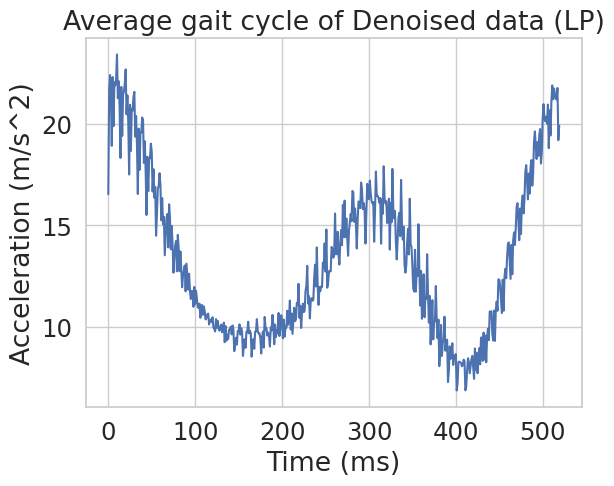

In [ ]:
average_gait_phase_cycle_lp.mag_filtered_lp.plot(title="Average gait cycle of Denoised data (LP)", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

<Axes: title={'center': 'Zoomed view of average cycle of Filtered Data (LP)'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

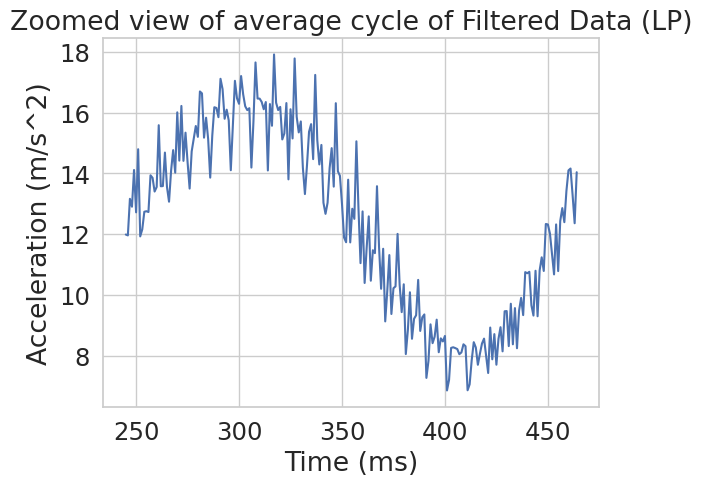

In [ ]:
average_gait_phase_cycle_lp.mag_filtered_lp.iloc[245:465].plot(title="Zoomed view of average cycle of Filtered Data (LP)", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

In [ ]:
smoothen_cycle_lp = average_gait_phase_cycle_lp.mag_filtered_lp.iloc[245:465].rolling(window=10).mean()

<Axes: title={'center': 'Zoomed view of average cycle of denoised data (LP) (Smoothen by moving avg filter)'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

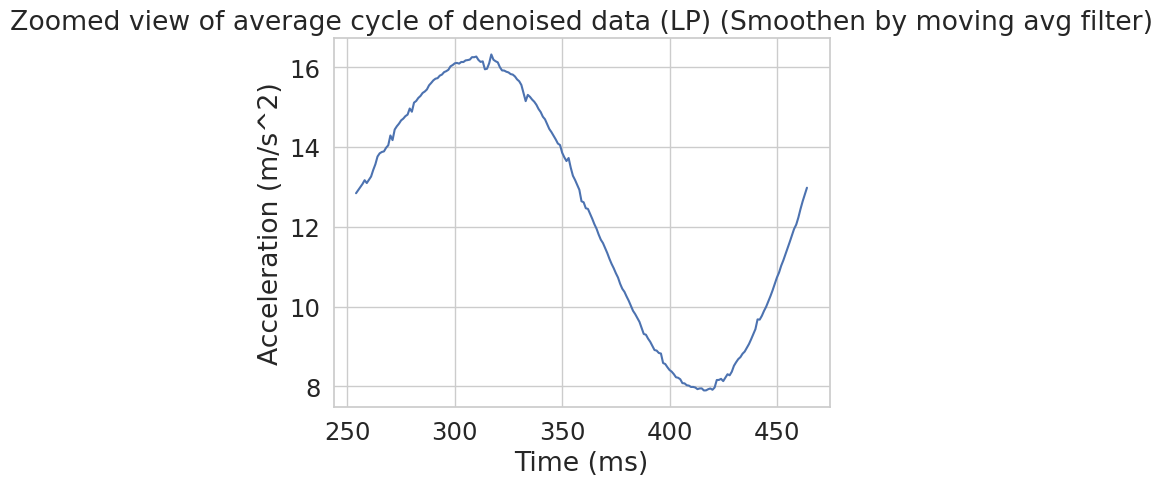

In [ ]:
smoothen_cycle_lp.plot(title="Zoomed view of average cycle of denoised data (LP) (Smoothen by moving avg filter)", xlabel="Time (ms)", ylabel="Acceleration (m/s^2)")

### Stats of Filtered Data (LP)

In [ ]:
inner_cycle_lp = average_gait_phase_cycle_lp.mag_filtered_lp.iloc[240:450]

inner_cycle_lp.describe()

count    210.000000
mean      12.380542
std        3.059861
min        6.851674
25%        9.358162
50%       12.741085
75%       15.145445
max       17.914247
Name: mag_filtered_lp, dtype: float64

Text(0, 0.5, 'Acceleration (m/s^2)')

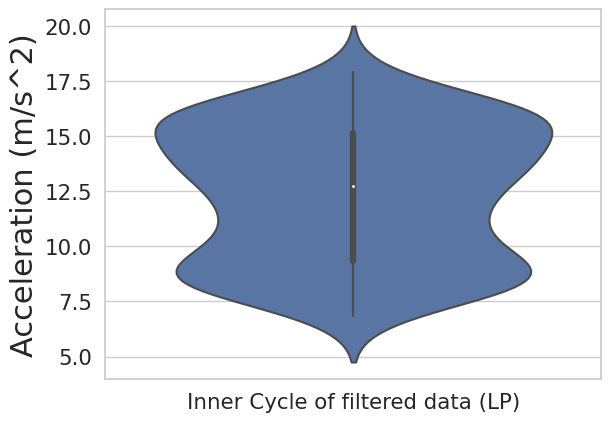

In [ ]:
import seaborn

seaborn.set(font_scale = 1.4, style = 'whitegrid')

tip = seaborn.load_dataset('tips')

# Pandas dataframe
data = pd.DataFrame({"Inner Cycle of filtered data (LP)": inner_cycle_lp})

plots = seaborn.violinplot(data = data)

plots.set_ylabel("Acceleration (m/s^2)", fontsize = 22)

In [ ]:
from scipy.stats import norm, kde

# Compute the PDF using KDE
kde = kde.gaussian_kde(inner_cycle_lp)
x = np.linspace(inner_cycle_lp.min(), inner_cycle_lp.max(), 1000)  # Generate a range of values for the x-axis
pdf_values = kde(x)

<ipython-input-57-081a9b3e3ae7>:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde = kde.gaussian_kde(inner_cycle_lp)


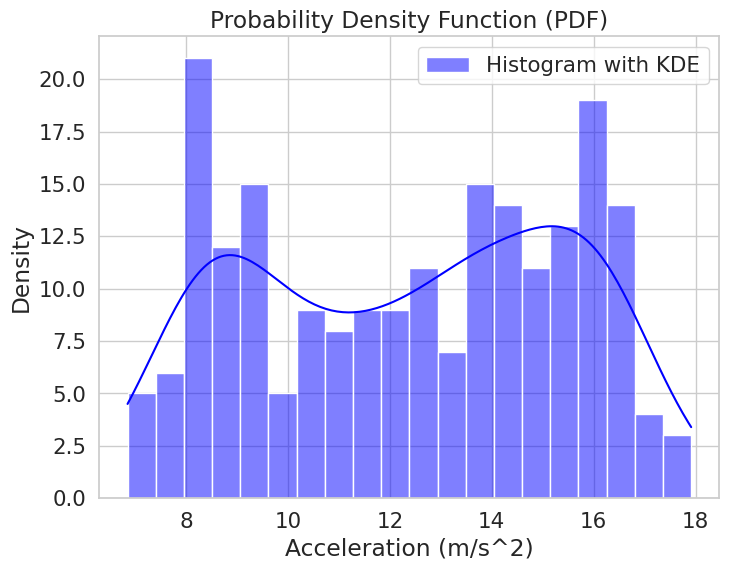

In [ ]:
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(8, 6))
ax = sns.histplot(inner_cycle_lp, kde=True, color='blue', bins=20, label='Histogram with KDE')  # Plot histogram with KDE

ax.set_xlabel('Acceleration (m/s^2)')
ax.set_ylabel('Density')
ax.set_title('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()